# Load Libraries

In [91]:
# Cargar librerias
from __future__ import absolute_import, division, print_function, unicode_literals
import os
from datetime import datetime
import datetime as dt  # Used to manage dates
import warnings                   # To ignore the warnings warnings.filterwarnings("ignore")
import requests
import pymysql # Import MySql 
from sqlalchemy import create_engine

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams 
import seaborn as sns

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

import plotly.offline as py
from plotly import graph_objs as go
from plotly import figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots

# Definir el ambiente de SQL
pymysql.install_as_MySQLdb()

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

pd.plotting.register_matplotlib_converters()
plt.rcParams['figure.figsize'] = 16,12
pd.options.display.float_format = '{:.4f}'.format
%matplotlib inline
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_info_rows', 100)

# Load Data

View created in SQL to extract the data
CREATE 
    ALGORITHM = UNDEFINED 
    DEFINER = `root`@`localhost` 
    SQL SECURITY DEFINER
VIEW `capstone_ai`.`household_view` AS
    SELECT 
        `a`.`membership_id` AS `membership_id`,
        `a`.`income` AS `income`,
        `a`.`member_status` AS `member_status`,
        `a`.`state_grouped` AS `state_grouped`,
        `a`.`credit_ranges` AS `credit_ranges`,
        `a`.`cancel_reason` AS `cancel_reason`,
        `a`.`renew_method` AS `renew_method`,
        `a`.`plus_indicator_description` AS `plus_indicator_description`,
        `a`.`zip` AS `zip`,
        `a`.`sc_vehicle_manufacturer_name` AS `sc_vehicle_manufacturer_name`,
        `a`.`sc_vehicle_model_name` AS `sc_vehicle_model_name`,
        `a`.`race` AS `race`,
        `a`.`home_owner` AS `home_owner`,
        `a`.`education` AS `education`,
        `a`.`dwelling_type` AS `dwelling_type`,
        `a`.`gender` AS `gender`,
        `a`.`occupation_code` AS `occupation_code`,
        `a`.`occupation_group` AS `occupation_group`,
        `a`.`occupant_type` AS `occupant_type`,
        `a`.`mosaic_household` AS `mosaic_household`,
        `a`.`mosaic_global_household` AS `mosaic_global_household`,
        `a`.`kcl_b_ind_mosaicsgrouping` AS `kcl_b_ind_mosaicsgrouping`,
        `a`.`generation` AS `generation`,
        `a`.`tenure` AS `tenure`,
        `a`.`no_tenure` AS `aaa_no_tenure`,
        MAX(`a`.`member_tenure_years`) AS `aaa_member_tenure_years`,
        AVG(`a`.`age`) AS `aaa_mean_age`,
        AVG(`a`.`length_of_residence`) AS `length_of_residence`,
        COUNT(`a`.`breakdown_city`) AS `total_breakdown`,
        MAX(`a`.`fsv_mortgage_flag`) AS `aaa_mortgage`,
        MAX(`a`.`fsv_credit_card_flag`) AS `aaa_credit_card`,
        MAX(`a`.`fsv_deposit_program_flag`) AS `aaa_deposit`,
        MAX(`a`.`fsv_home_equity_flag`) AS `aaa_home_equity`,
        MAX(`a`.`fsv_cmsi_flag`) AS `aaa_financial_service`,
        MAX(`a`.`ins_client_flag`) AS `aaa_auto_insurance`,
        MAX(`a`.`motorcycle_indicator`) AS `aaa_motorcycle_indicator`,
        AVG(`a`.`no_child`) AS `aaa_mean_child`,
        AVG(`a`.`total_cost`) AS `aaa_mean_total_cost`,
        MAX(`a`.`no_race`) AS `aaa_no_race`,
        MAX(`a`.`no_home_owner`) AS `aaa_no_home_owner`,
        MAX(`a`.`no_education`) AS `aaa_no_education`,
        MAX(`a`.`no_income`) AS `aaa_no_income`,
        MAX(`a`.`no_dwelling_type`) AS `aaa_no_dwelling_type`,
        MAX(`a`.`no_credit_ranges`) AS `aaa_no_credit_ranges`,
        MAX(`a`.`no_gender`) AS `aaa_no_gender`,
        MAX(`a`.`no_language`) AS `aaa_no_language`,
        MAX(`a`.`no_reason_joined`) AS `aaa_no_reason_joined`,
        MAX(`a`.`no_cancel_reason`) AS `aaa_cancel_reason`,
        MAX(`a`.`no_mosaic_household`) AS `aaa_no_mosaic_household`,
        MAX(`a`.`no_mosaic_global_household`) AS `aaa_no_mosaic_global_household`,
        MAX(`a`.`no_kcl_b_ind_mosaicsgrouping`) AS `aaa_no_kcl_b_ind_mosaicsgrouping`,
        MAX(`a`.`no_occupation_code`) AS `aaa_no_occupation_code`,
        MAX(`a`.`no_occupation_group`) AS `aaa_no_occupation_group`,
        MAX(`a`.`no_occupant_type`) AS `aaa_no_occupant_type`,
        MAX(`a`.`no_plus_indicator_description`) AS `aaa_no_plus_indicator_description`,
        MAX(`a`.`no_generation`) AS `aaa_no_generation`,
        CONCAT(`a`.`sc_vehicle_manufacturer_name`,
                ' ',
                `a`.`sc_vehicle_model_name`) AS `vehicle`,
        SUM(`a`.`total_cost`) AS `total_cost`
    FROM
        `capstone_ai`.`capstone_aaa_featured` `a`
    WHERE
        ((`a`.`cancel_reason` <> 'Deceased')
            AND (`a`.`member_type` = 'Primary'))
    GROUP BY `a`.`membership_id`
    ORDER BY `a`.`membership_id`

In [94]:
# Load data from the View
db = pymysql.connect("localhost","root","cayila9090" ,database="capstone_ai")
cursor = db.cursor() 
query = """
select * from household_view;
"""
df_feature = pd.read_sql(query, con=db)
db.close()
df_feature.info(verbose=True,null_counts=True )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4760 entries, 0 to 4759
Data columns (total 58 columns):
membership_id                        4760 non-null int64
income                               4760 non-null object
member_status                        4760 non-null object
state_grouped                        4760 non-null object
credit_ranges                        4760 non-null object
cancel_reason                        4760 non-null object
renew_method                         4760 non-null object
plus_indicator_description           4760 non-null object
zip                                  4760 non-null int64
sc_vehicle_manufacturer_name         4760 non-null object
sc_vehicle_model_name                4760 non-null object
race                                 4760 non-null object
home_owner                           4760 non-null object
education                            4760 non-null object
dwelling_type                        4760 non-null object
gender                   

In [95]:
df_feature.head(10)

membership_id         income member_status state_grouped credit_ranges  \
0            153      30-39,999        ACTIVE            RI       600-649   
1            163      50-59,999        ACTIVE            RI       750-799   
2            182      50-59,999        ACTIVE            RI       650-699   
3            188    100-149,999        ACTIVE            RI       650-699   
4            191    100-149,999        ACTIVE            RI       750-799   
5            205  150 - 174,999        ACTIVE            RI       750-799   
6            208        Unknown        ACTIVE            RI       Unknown   
7            209        Unknown     CANCELLED            CT       Unknown   
8            263    100-149,999     CANCELLED            RI       650-699   
9            282    100-149,999        ACTIVE            RI       Unknown   

  cancel_reason renew_method plus_indicator_description   zip  \
0       Unknown   AUTO RENEW           Basic Membership  2893   
1       Unknown   AUTO RENEW           Basic Membership  2889   
2       Unknown       NOTICE           Basic Membership  2863   
3       Unknown       NOTICE           Basic Membership  2888   
4       Unknown       NOTICE           Basic Membership  2806   
5       Unknown       NOTICE           Basic Membership  2879   
6       Unknown   AUTO RENEW           Basic Membership  2920   
7   Non-Payment       NOTICE           Basic Membership  6111   
8   Non-Payment       NOTICE                    Unknown  2892   
9       Unknown       NOTICE            Plus Membership  2814   

  sc_vehicle_manufacturer_name sc_vehicle_model_name  \
0                       TOYOTA                 CAMRY   
1                       SUBARU              FORESTER   
2                     INFINITI                  QX56   
3                     CHRYSLER               SEBRING   
4                          GMC               TERRAIN   
5                        ACURA                    TL   
6                    CHEVROLET                 SONIC   
7                      HYUNDAI                TUCSON   
8                      Unknown               Unknown   
9                        DODGE              RAM 2500   

                           race  home_owner     education  \
0   Caucasion / White - English  Home Owner  Some College   
1  Caucasion / White - European  Home Owner   High School   
2  Caucasion / White - European  Home Owner  Some College   
3  Caucasion / White - European  Home Owner       Unknown   
4         Middle Eastern - Arab  Home Owner  Some College   
5    Hispanic - Hispanic Origin  Home Owner  Some College   
6                       Unknown     Unknown       Unknown   
7                       Unknown     Unknown       Unknown   
8  Caucasion / White - European  Home Owner       Unknown   
9    Hispanic - Hispanic Origin  Home Owner       Unknown   

                              dwelling_type   gender  \
0  Small or large multi-family w/apt number  Unknown   
1                                      SFDU  Unknown   
2                                      SFDU     Male   
3                                      SFDU  Unknown   
4                                      SFDU  Unknown   
5                                      SFDU     Male   
6                                   Unknown  Unknown   
7                                   Unknown  Unknown   
8                                      SFDU  Unknown   
9                                  P.O. BOX     Male   

              occupation_code    occupation_group occupant_type  \
0                     Unknown             Unknown       Unknown   
1                     Unknown             Unknown       Unknown   
2                     Retired     Retired - Known       Unknown   
3                     Unknown             Unknown       Unknown   
4                     Unknown             Unknown       Unknown   
5                     Unknown  Retired - Inferred       Unknown   
6                     Unknown             Unknown       Unknown 

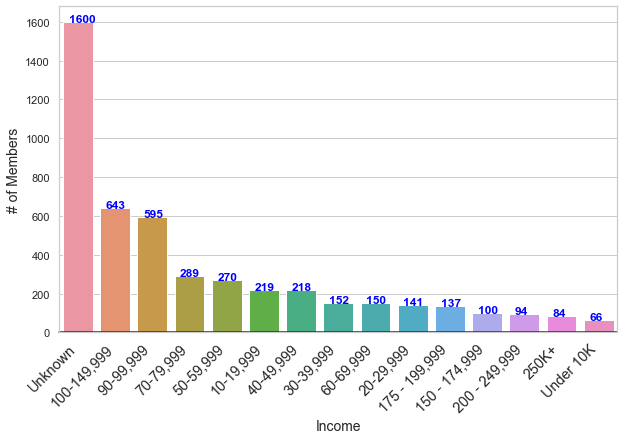

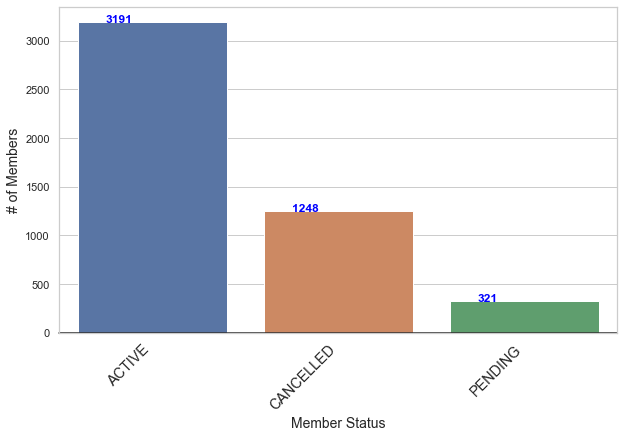

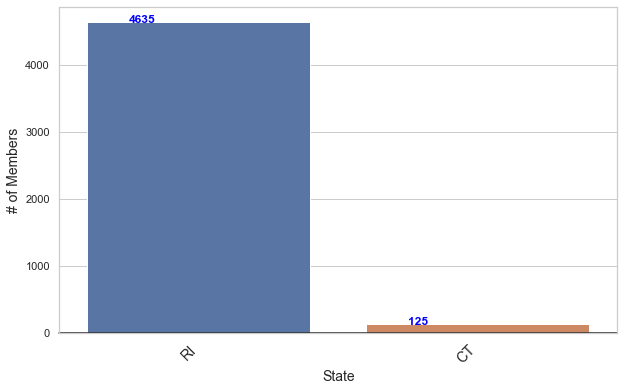

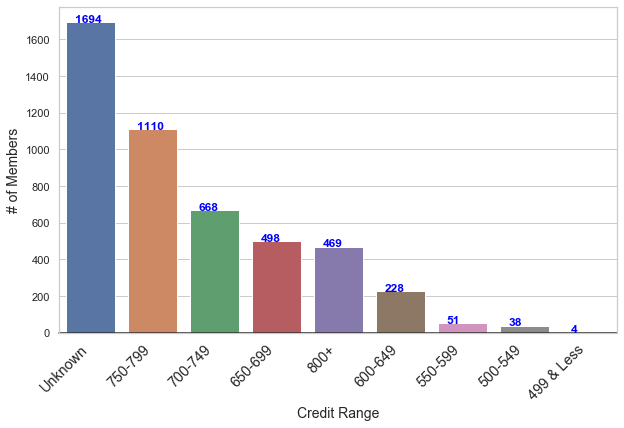

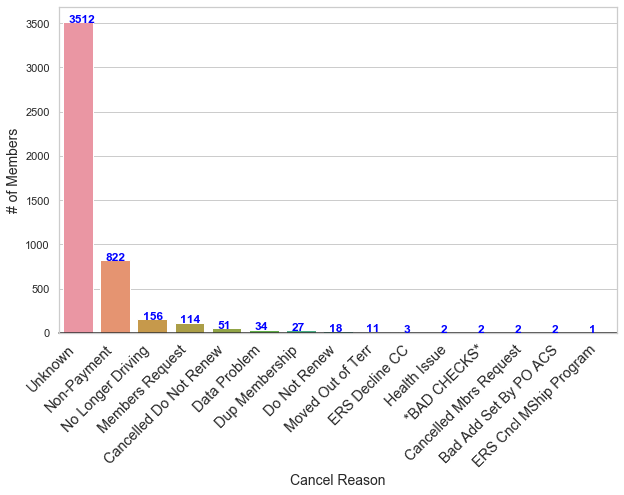

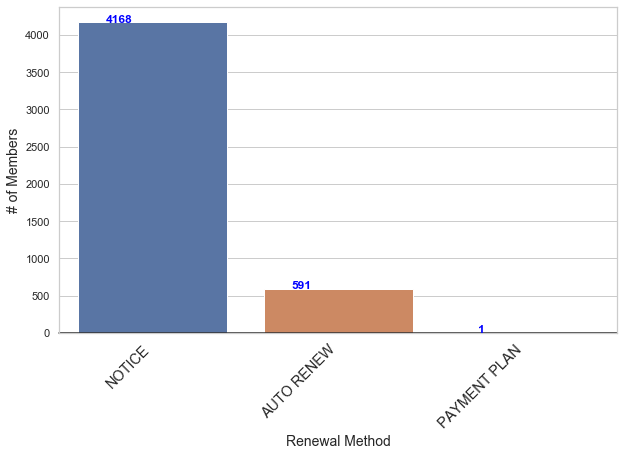

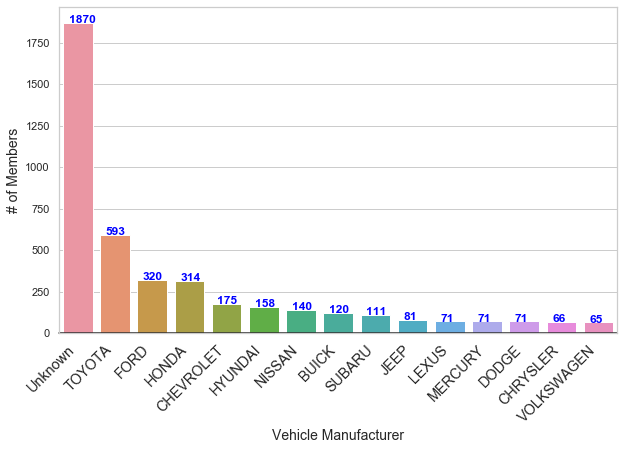

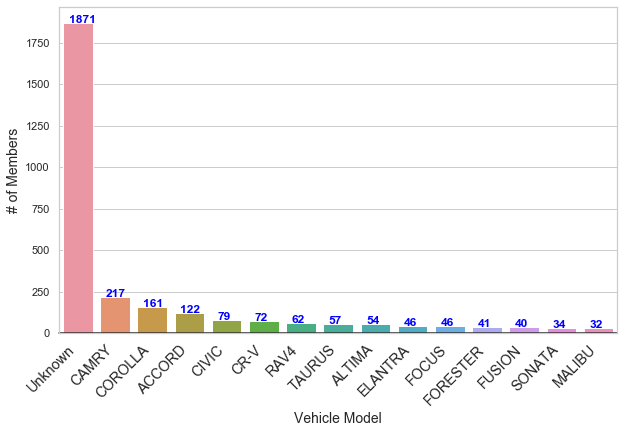

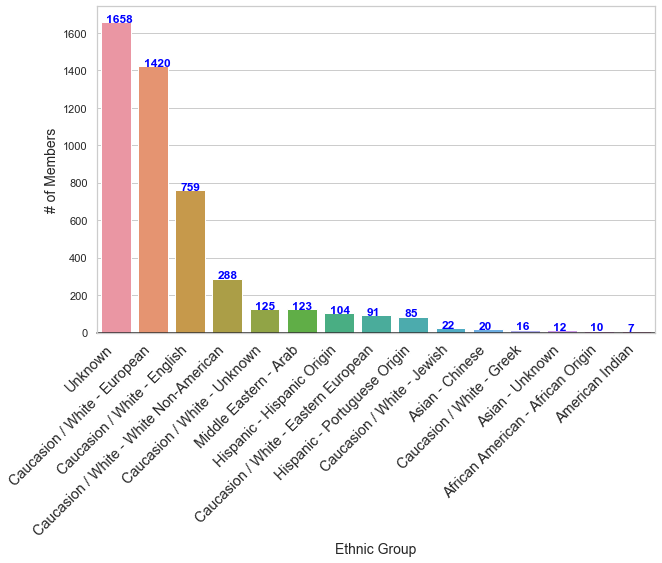

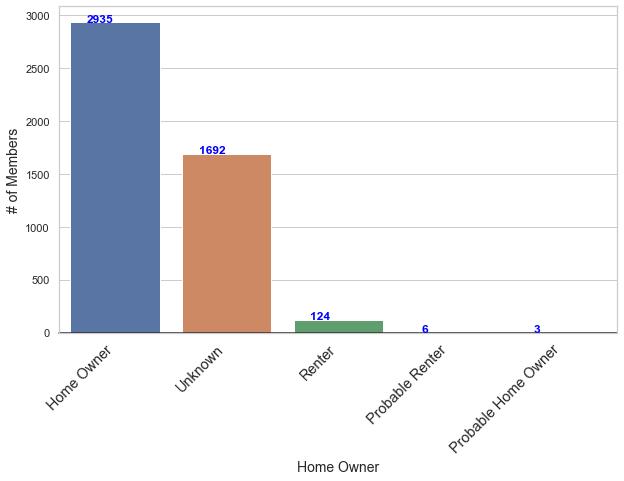

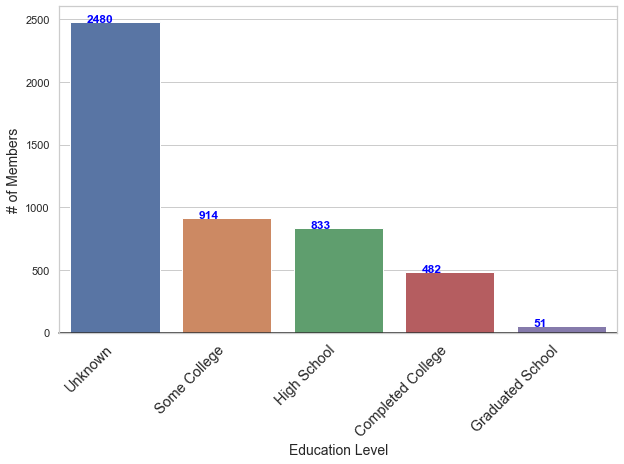

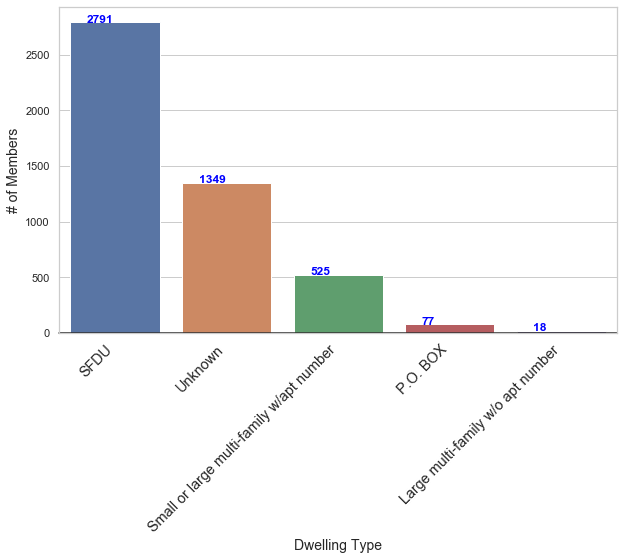

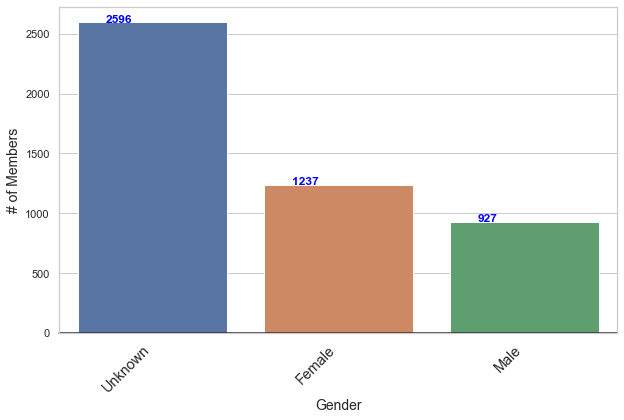

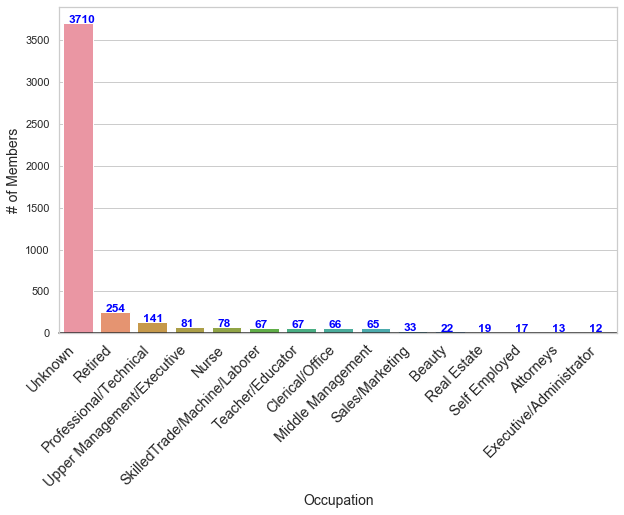

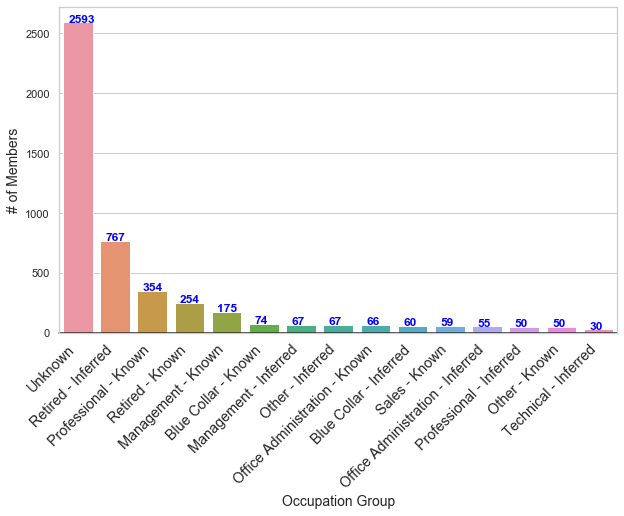

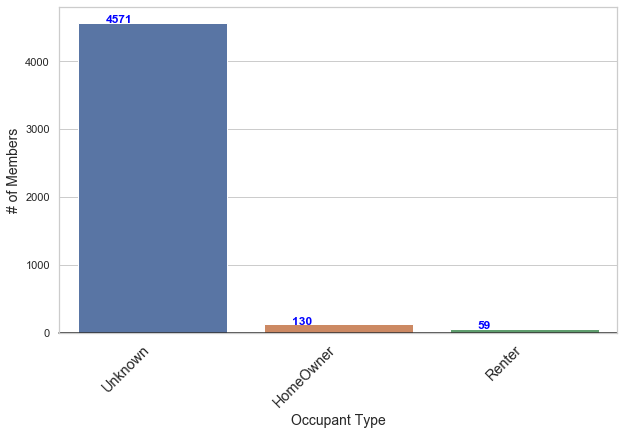

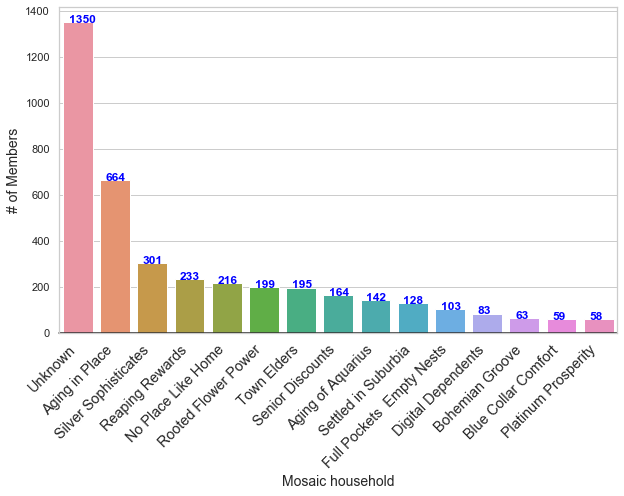

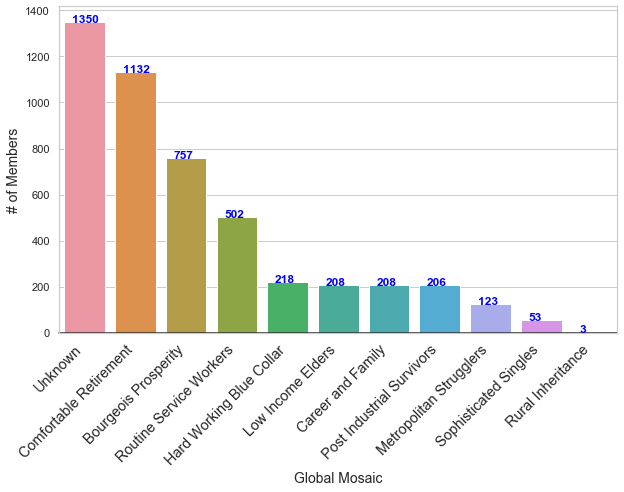

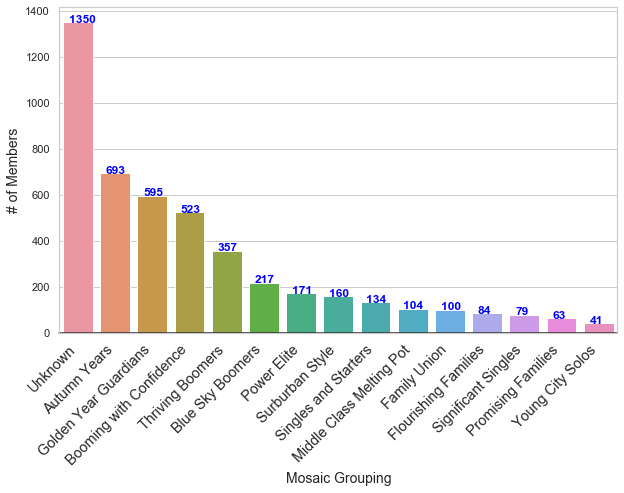

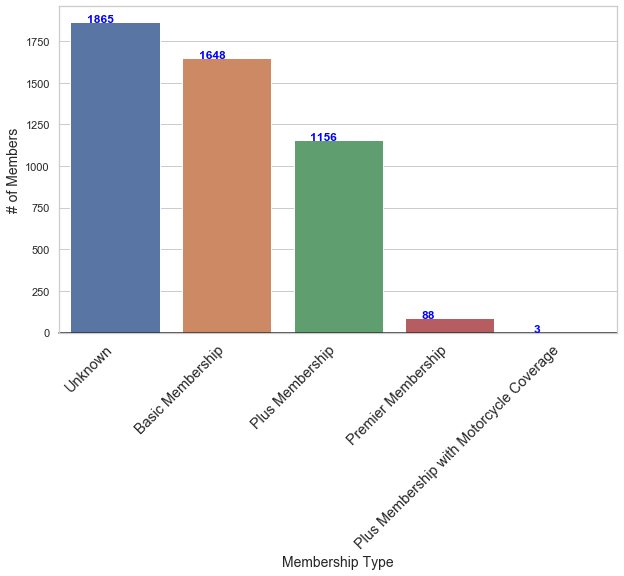

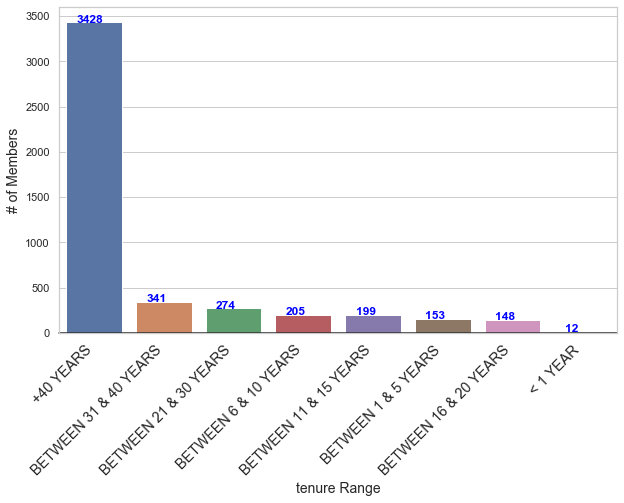

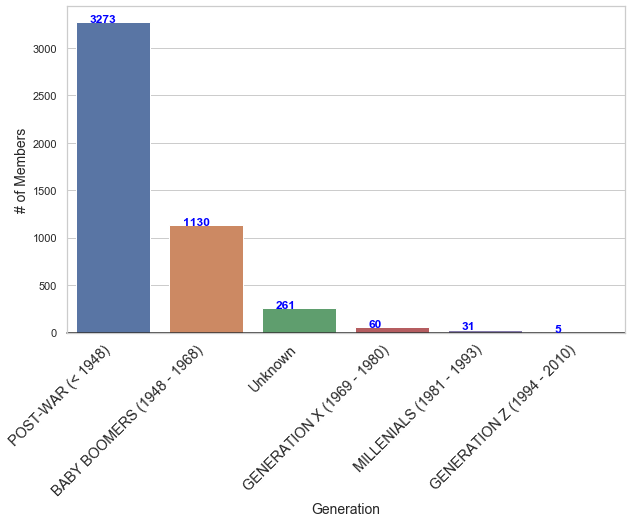

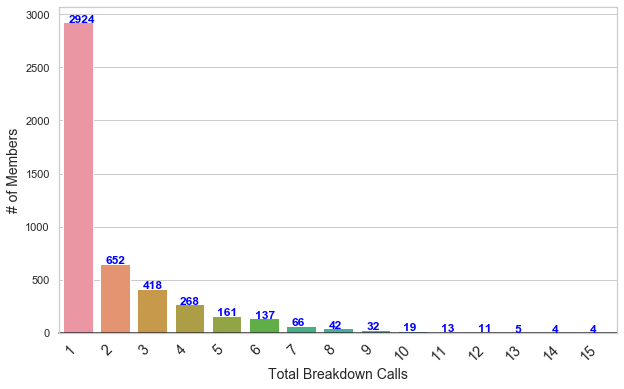

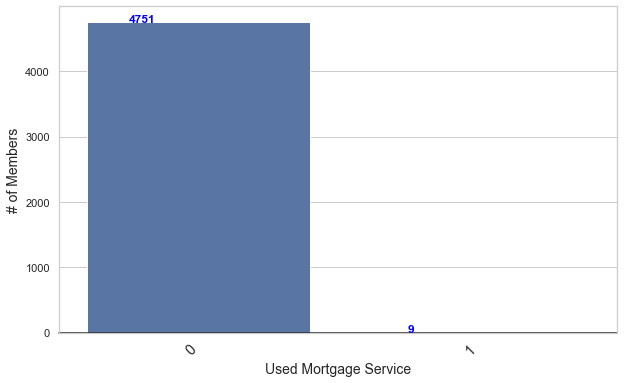

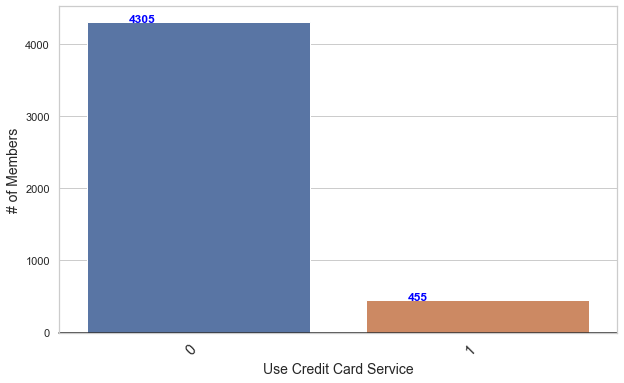

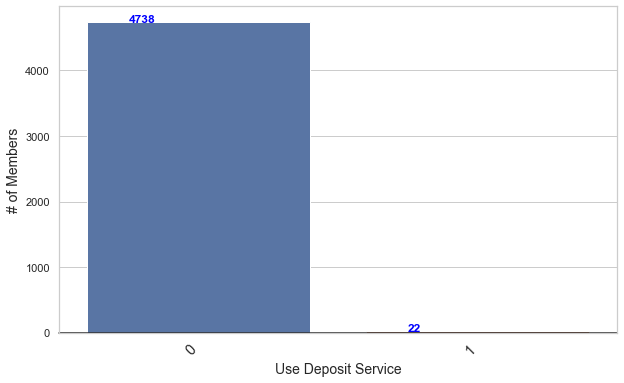

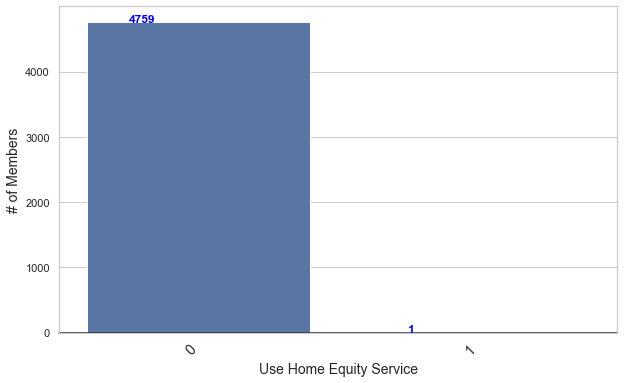

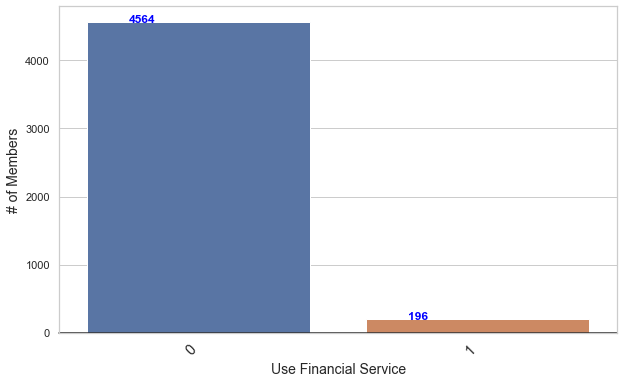

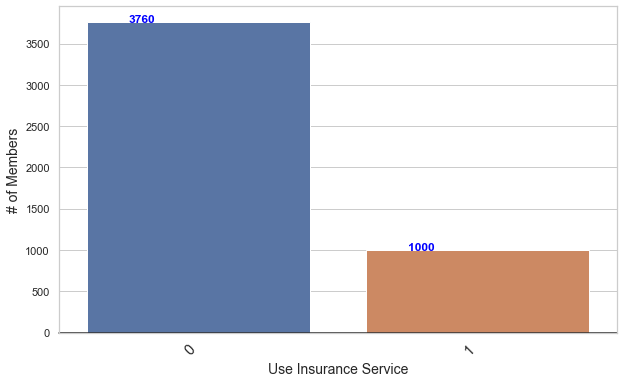

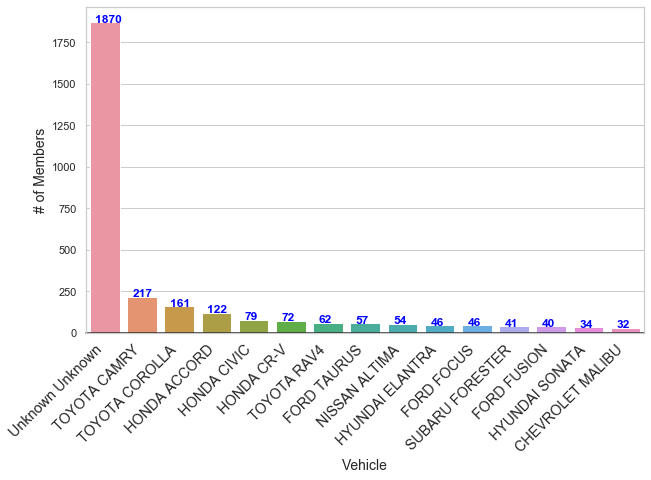

In [203]:
# Several Graphs
# Columns to graph
cols = [ 'income', 'member_status','state_grouped', 'credit_ranges', 'cancel_reason','renew_method',
        'sc_vehicle_manufacturer_name','sc_vehicle_model_name','race','home_owner','education', 
        'dwelling_type', 'gender','occupation_code', 'occupation_group', 'occupant_type','mosaic_household',
        'mosaic_global_household','kcl_b_ind_mosaicsgrouping', 'plus_indicator_description',
        'tenure', 'generation', 'total_breakdown', 'aaa_mortgage', 'aaa_credit_card',
        'aaa_deposit', 'aaa_home_equity', 'aaa_financial_service', 'aaa_auto_insurance', 'vehicle'
       ]

# Dictionary for X Axis Labels
dict_cols = { 'income':'Income', 'member_status':'Member Status','state_grouped': 'State', 'credit_ranges':'Credit Range',
             'cancel_reason':'Cancel Reason','renew_method':'Renewal Method','sc_vehicle_manufacturer_name':'Vehicle Manufacturer',
             'sc_vehicle_model_name':'Vehicle Model','race': 'Ethnic Group','home_owner': 'Home Owner','education':'Education Level', 
             'dwelling_type': 'Dwelling Type', 'gender':'Gender','occupation_code':'Occupation', 'occupation_group':'Occupation Group',
             'occupant_type': 'Occupant Type','mosaic_household':'Mosaic household','mosaic_global_household':'Global Mosaic',
             'kcl_b_ind_mosaicsgrouping':'Mosaic Grouping', 'plus_indicator_description':'Membership Type',
             'tenure':'tenure Range', 'generation':'Generation', 'total_breakdown':'Total Breakdown Calls', 
             'aaa_mortgage':'Used Mortgage Service', 'aaa_credit_card':'Use Credit Card Service','aaa_deposit':'Use Deposit Service',
             'aaa_home_equity':'Use Home Equity Service', 'aaa_financial_service':'Use Financial Service', 
             'aaa_auto_insurance':'Use Insurance Service', 'vehicle':'Vehicle'
             
            }


# number of members per state
plt.rcParams['figure.figsize'] = 10,6

for col in cols:
    counts = df_feature[col].value_counts().nlargest(15)
    sns.set(style="whitegrid")
    plt.axhline(0, color="k", clip_on=False)
    plt.ylabel("# of Members",fontsize=14)
    plt.xlabel(dict_cols[col], fontsize=14)
    sns.barplot(counts.index, counts.values)
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='large')
    i = 0
    for v in list(counts.values):
        plt.text(i-.25, v, str(v), color='blue', fontweight='bold')
        i +=1
    plt.show()
    counts = pd.DataFrame(df_feature[col].value_counts().nlargest(15), index=None)
    counts.reset_index(inplace=True)
    counts.rename(columns={"index": dict_cols[col], col: "# of Members"}, inplace=True)
    #print(df_feature[col].value_counts().nlargest(15),'\n\n')
    fig = ff.create_table(counts, height_constant=30, index=False)
    py.iplot(fig)

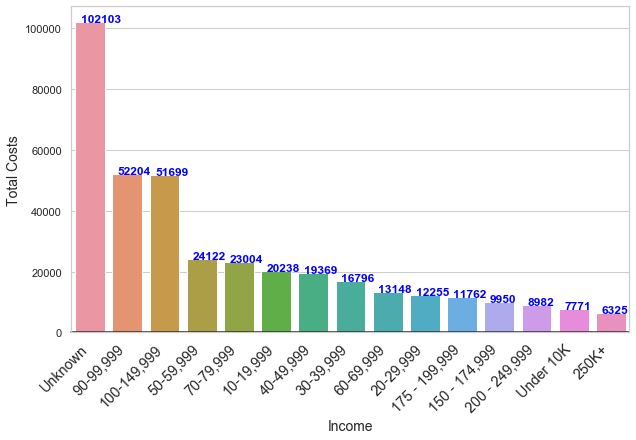

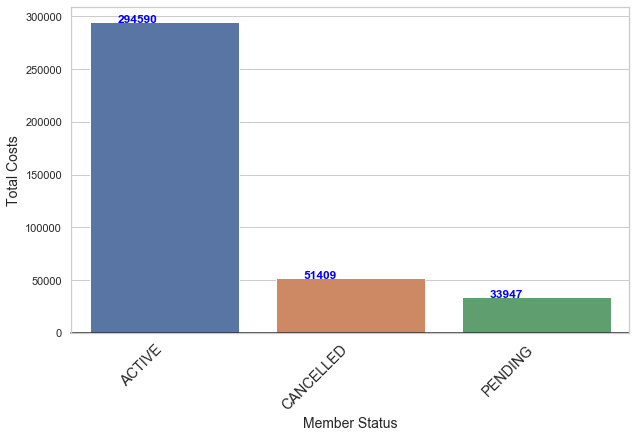

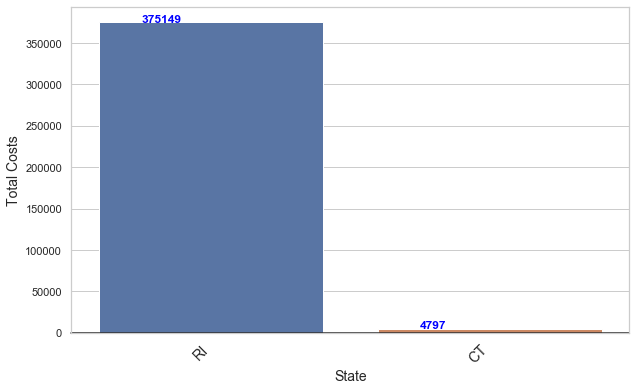

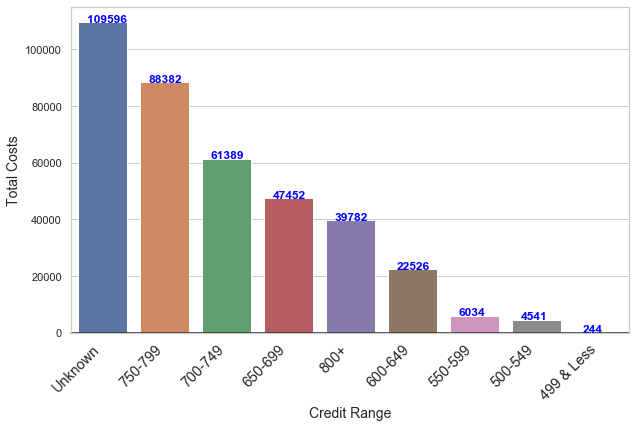

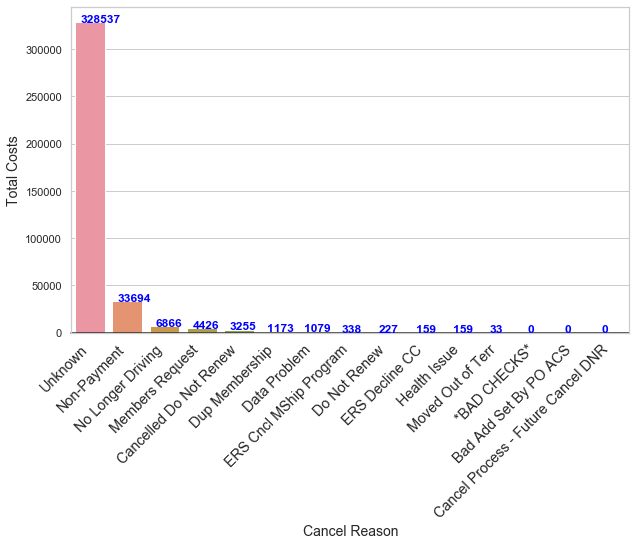

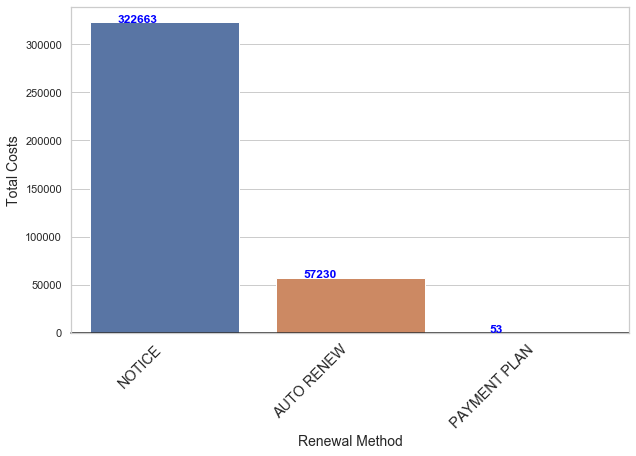

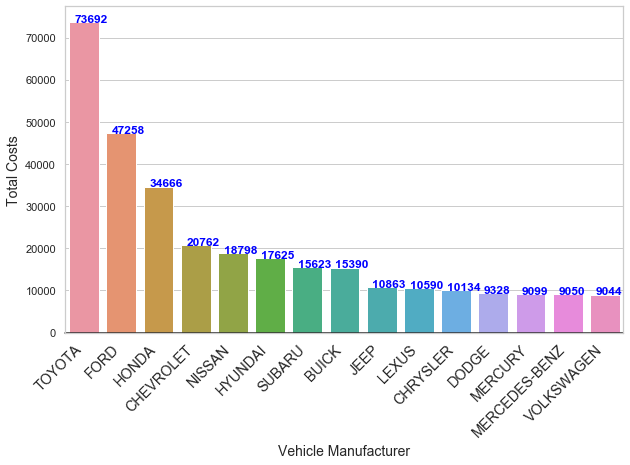

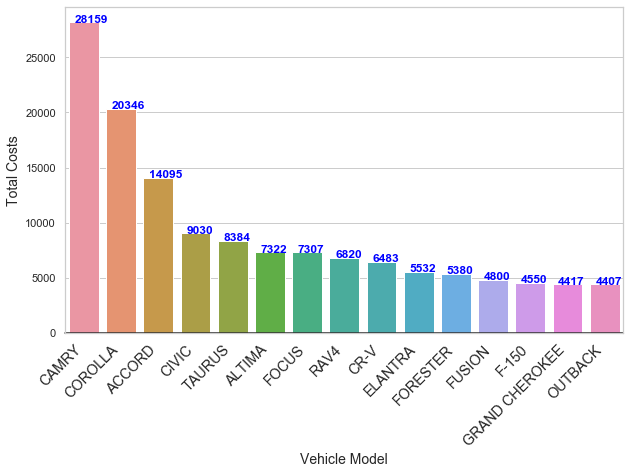

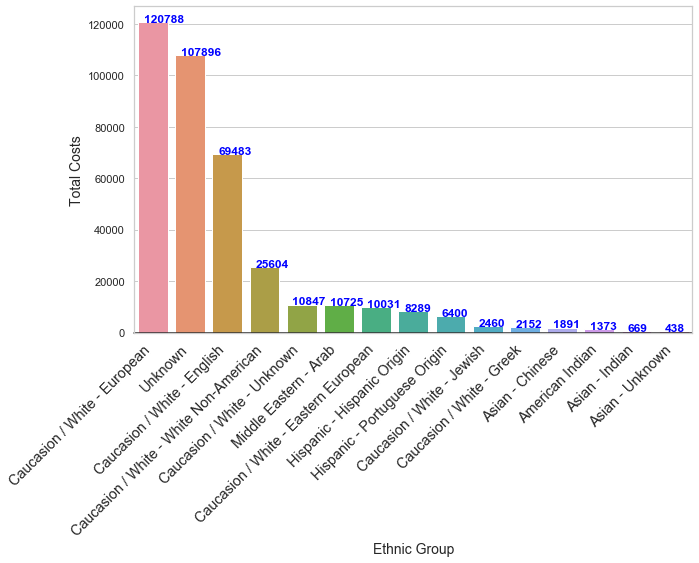

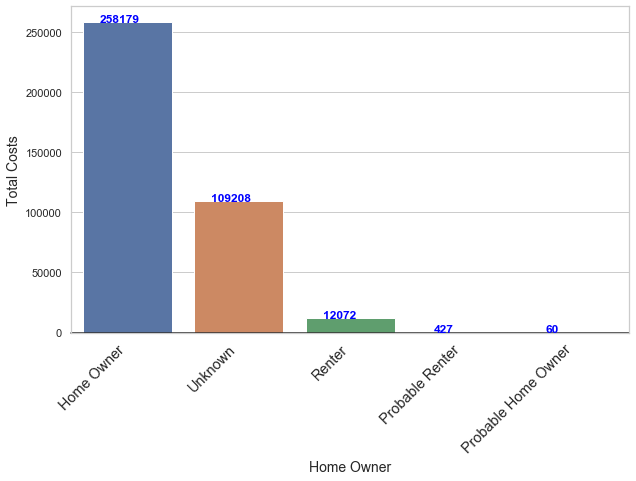

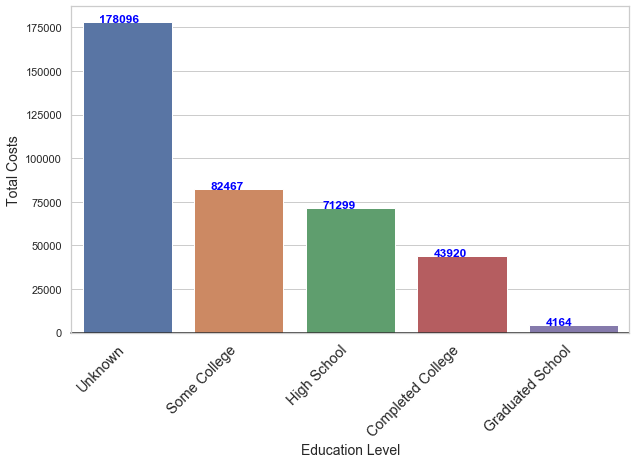

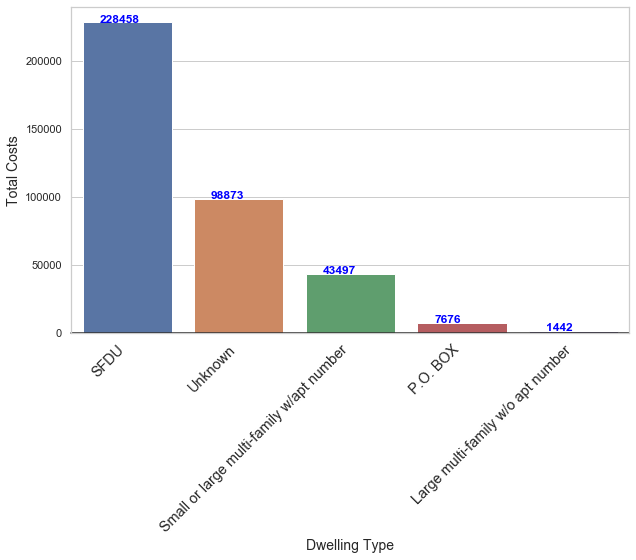

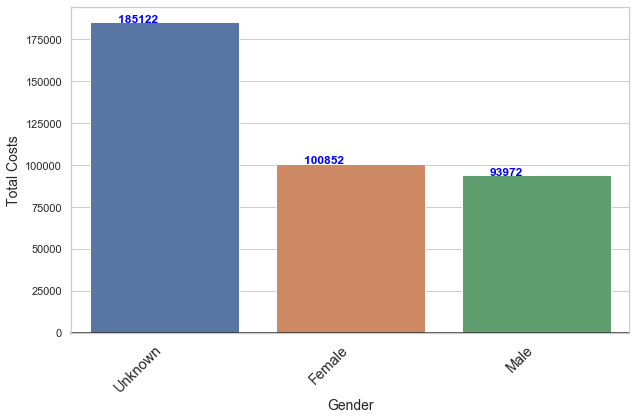

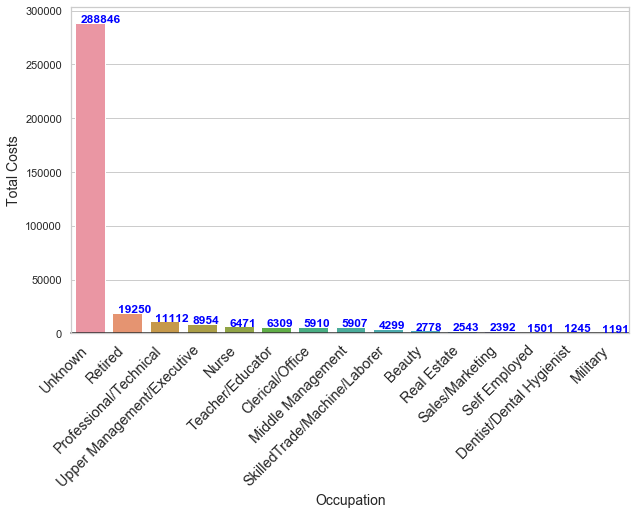

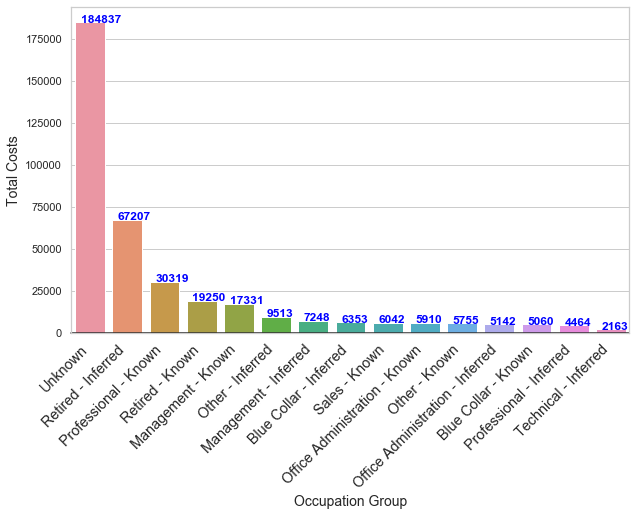

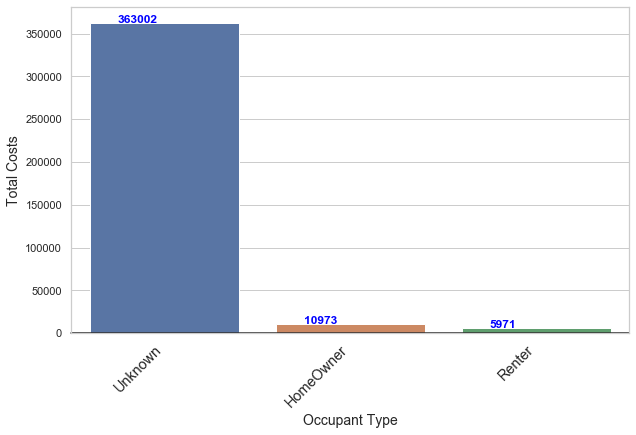

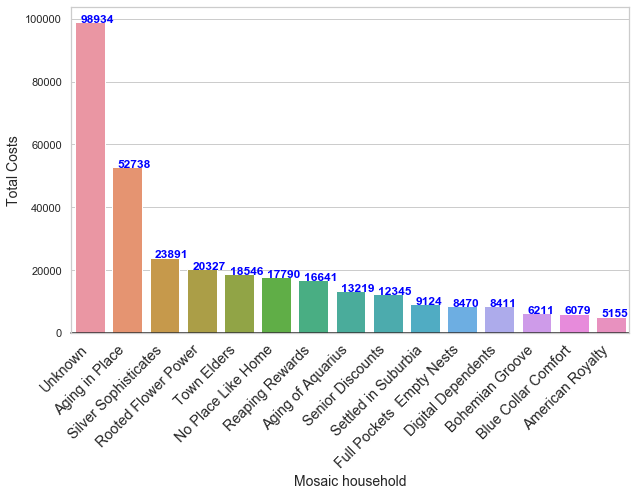

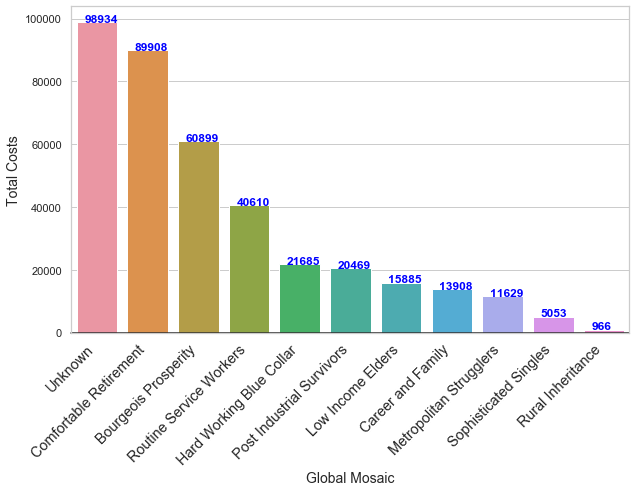

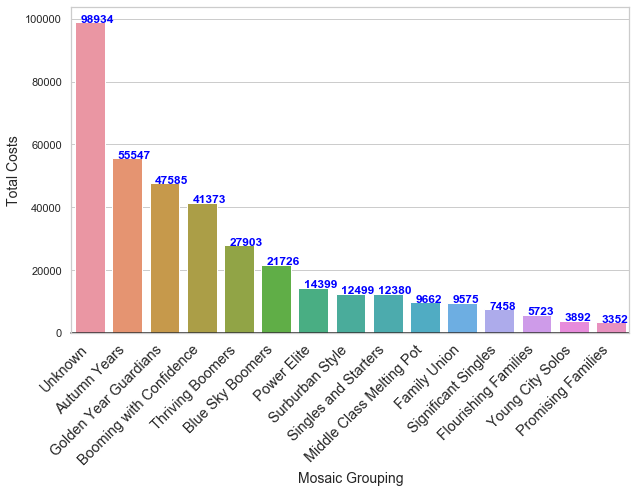

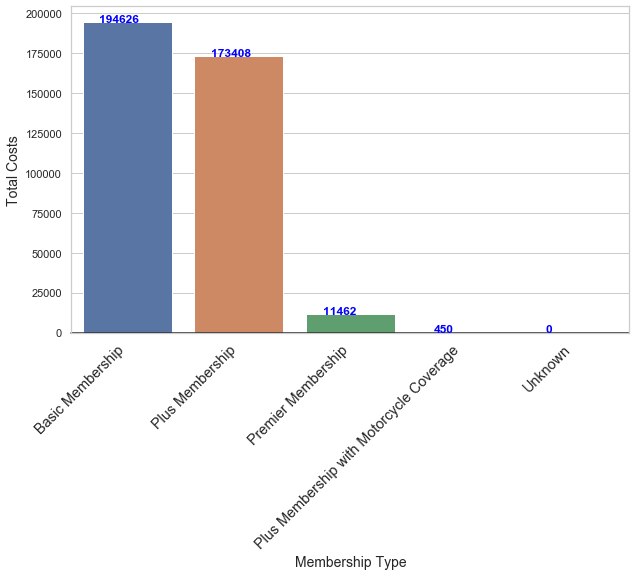

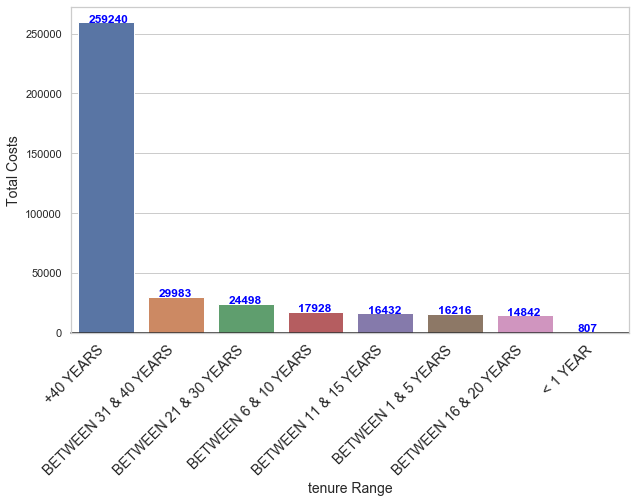

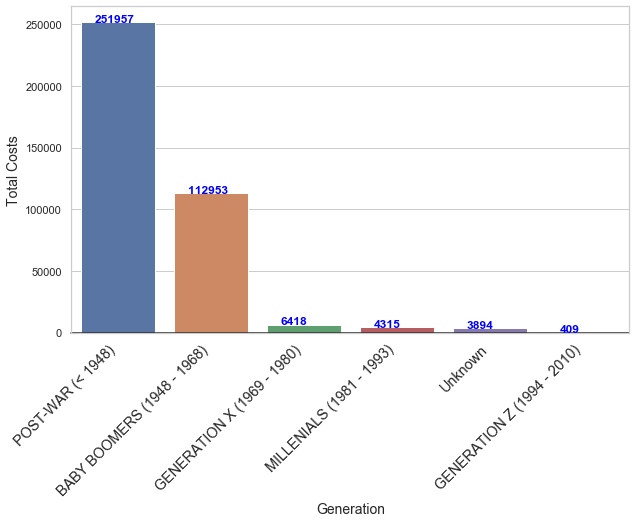

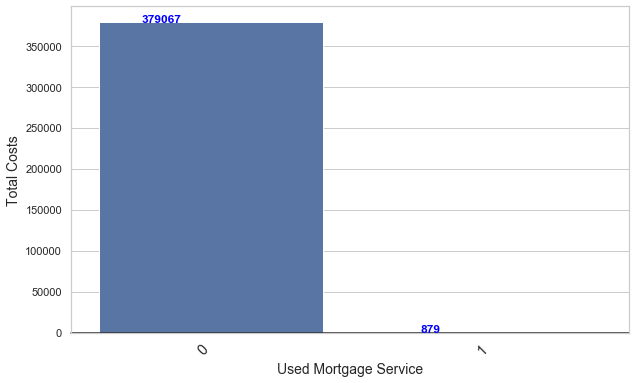

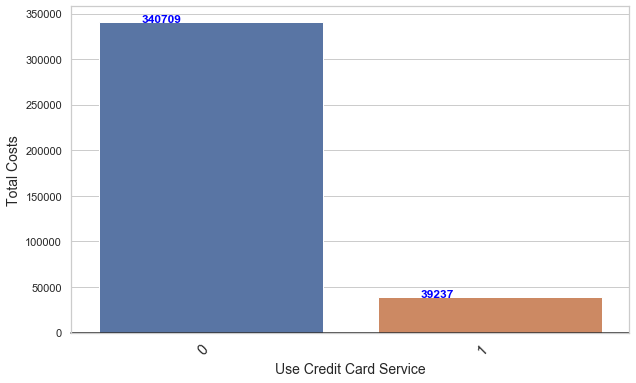

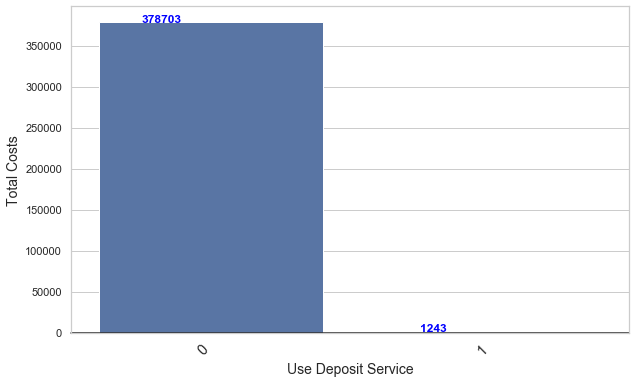

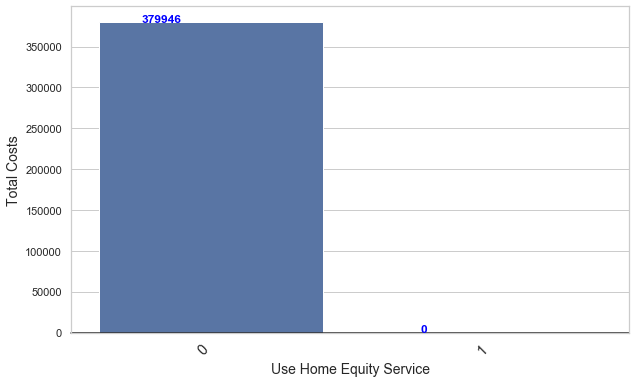

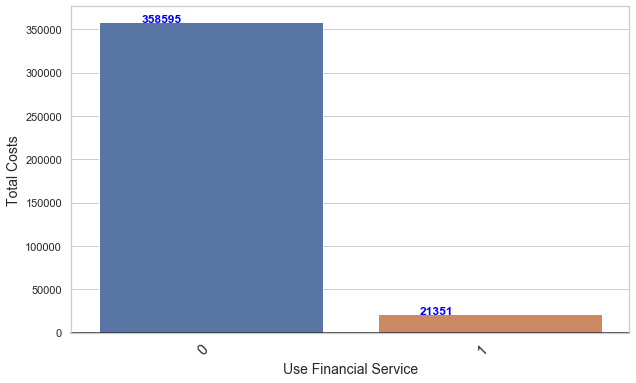

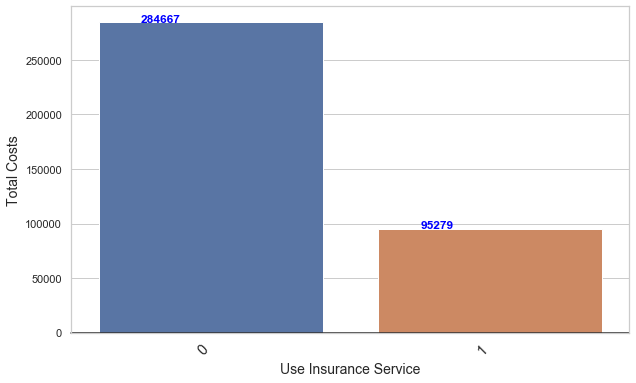

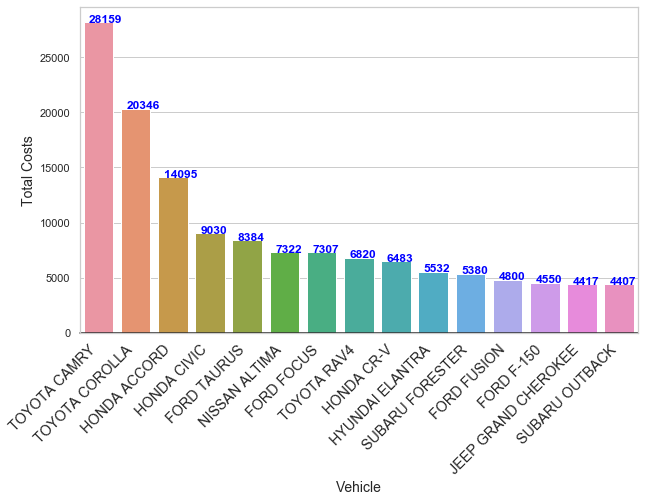

In [204]:
# Find 

# Columns to graph

cols = [ 'income', 'member_status','state_grouped', 'credit_ranges', 'cancel_reason','renew_method',
        'sc_vehicle_manufacturer_name','sc_vehicle_model_name','race','home_owner','education', 
        'dwelling_type', 'gender','occupation_code', 'occupation_group', 'occupant_type','mosaic_household',
        'mosaic_global_household','kcl_b_ind_mosaicsgrouping', 'plus_indicator_description',
        'tenure', 'generation', 'aaa_mortgage', 'aaa_credit_card',
        'aaa_deposit', 'aaa_home_equity', 'aaa_financial_service', 'aaa_auto_insurance', 'vehicle'
       ]

# Dictionary for X Axis Labels
dict_cols = { 'income':'Income', 'member_status':'Member Status','state_grouped': 'State', 'credit_ranges':'Credit Range',
             'cancel_reason':'Cancel Reason','renew_method':'Renewal Method','sc_vehicle_manufacturer_name':'Vehicle Manufacturer',
             'sc_vehicle_model_name':'Vehicle Model','race': 'Ethnic Group','home_owner': 'Home Owner','education':'Education Level', 
             'dwelling_type': 'Dwelling Type', 'gender':'Gender','occupation_code':'Occupation', 'occupation_group':'Occupation Group',
             'occupant_type': 'Occupant Type','mosaic_household':'Mosaic household','mosaic_global_household':'Global Mosaic',
             'kcl_b_ind_mosaicsgrouping':'Mosaic Grouping', 'plus_indicator_description':'Membership Type','tenure':'tenure Range', 'generation':'Generation', 
             'aaa_mortgage':'Used Mortgage Service', 'aaa_credit_card':'Use Credit Card Service','aaa_deposit':'Use Deposit Service',
             'aaa_home_equity':'Use Home Equity Service', 'aaa_financial_service':'Use Financial Service', 
             'aaa_auto_insurance':'Use Insurance Service', 'vehicle':'Vehicle'
             
            }


# number of members per state
plt.rcParams['figure.figsize'] = 10,6
for col in cols:
    df_cols = [col, 'total_cost']
    df = pd.DataFrame(data=df_feature,columns=df_cols)
    df.total_cost = df.total_cost.apply(lambda x: int(x))
    df = df.groupby(by=col, axis=0, level=None, as_index=False, sort=True, group_keys=True, squeeze=True,observed=False,).sum().nlargest(15,'total_cost')
    df.sort_values(by='total_cost', ascending=False,inplace=True)
    sns.set(style="whitegrid")
    sns.barplot(df[col], df['total_cost'])
    plt.axhline(0, color="k", clip_on=False)
    plt.ylabel("Total Costs",fontsize=14)
    plt.xlabel(dict_cols[col], fontsize=14)
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='large')
    i = 0
    for v in list(df.total_cost):
        plt.text(i-.25, v, str(v), color='blue', fontweight='bold')
        i +=1
    plt.show()
    df.rename(columns={col: dict_cols[col], 'total_cost': "Total Costs"}, inplace=True)
    fig = ff.create_table(df, height_constant=30, index=False)
    py.iplot(fig)

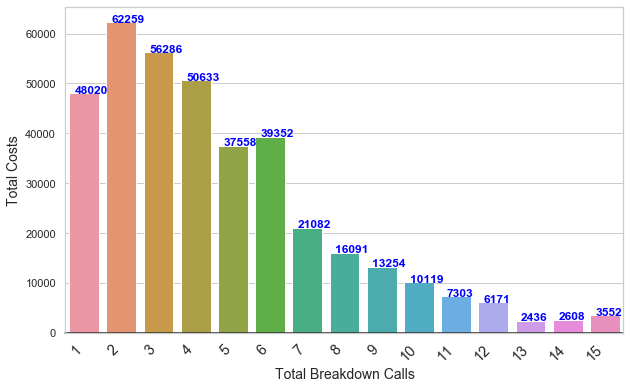

In [205]:
# Numbers of breakdown calls vs. total_cost
plt.rcParams['figure.figsize'] = 10,6
df_cols = ['total_breakdown', 'total_cost']
df = pd.DataFrame(data=df_feature,columns=df_cols)
df.total_cost = df.total_cost.apply(lambda x: int(x))
df = df.groupby(by='total_breakdown', axis=0, level=None, as_index=False, sort=True, group_keys=True, squeeze=True,observed=False,).sum().nlargest(15,'total_cost')
df.sort_values(by='total_breakdown', ascending=True, inplace=True)
sns.set(style="whitegrid")
sns.barplot(df['total_breakdown'], df['total_cost'])
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Total Costs",fontsize=14)
plt.xlabel('Total Breakdown Calls', fontsize=14)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large')
i = 0
for v in list(df.total_cost):
    plt.text(i-.25, v, str(v), color='blue', fontweight='bold')
    i +=1
plt.show()
df.rename(columns={"total_breakdown": 'Total Breakdown Calls', 'total_cost': "Total Costs"}, inplace=True)
fig = ff.create_table(df, height_constant=30, index=False)
py.iplot(fig, image_width=100,image_height=100)

# Function Definitions